In [75]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import defaultdict

data = pd.read_csv("data/TCGAdata.txt", sep=" ")
labels = pd.read_csv("data/TCGAlabels", sep=" ")


# Define classifiers
classifiers = [
    ("k-Nearest Neighbors (k=3)", KNeighborsClassifier, {"n_neighbors": 3}),
    ("Decision Tree", DecisionTreeClassifier, {"max_depth": 7}),
    ("k-Nearest Neighbors (k=30)", KNeighborsClassifier, {"n_neighbors": 30}),
]

num_principal_components = range(1, 20)

# scale the data for PCA
data = StandardScaler().fit_transform(data)

# scale data with min-max scaler for variance threshold
min_max_scaler = MinMaxScaler()
scaled_data = min_max_scaler.fit_transform(data)

all_results_pca = []
all_results_var = []

for test_size in [0.2, 0.4, 0.8]:
    
    results = defaultdict(lambda: [])
    results_var = defaultdict(lambda: [])
    
    
    for name, classifier_class, params in classifiers:

        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, random_state=42)
        X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(scaled_data, labels, test_size=test_size, random_state=42)
        
        print(f"train size: {len(X_train)} ({(1 - test_size)*100}%) test size: {len(X_test)} ({(test_size)*100}%)")
        best_pca_score = 0
        best_pca_num_components = 0
        
        best_var_score = 0
        best_var_threshold = 0
        for num_compontents in num_principal_components:
            # Fit PCA
            pca = PCA(n_components=num_compontents)
            pca.fit(X_train)
            X_train_pca = pca.transform(X_train)

            # Evaluate classifier
            classifier = classifier_class(**params)
            scores = cross_val_score(classifier, X_train_pca, y_train.values.ravel(), cv=5)
            # print(f"{name} with {num_compontents} principal components")
            # print(f"Cross-validation scores: {scores}")
            results[name].append((1 - scores, num_compontents))
            scores = scores.mean()
            if scores > best_pca_score:
                best_pca_score = scores
                best_pca_num_components = num_compontents
                
        for threshold in [0.06, 0.07, 0.08, 0.09, 0.10]:
            selector = VarianceThreshold(threshold=threshold)
            selector.fit(X_train_scaled)
            X_train_selected = selector.transform(X_train_scaled)
            classifier = classifier_class(**params)
            scores = cross_val_score(classifier, X_train_selected, y_train_scaled.values.ravel(), cv=5)
            
            results_var[name].append((1 - scores, threshold))
            scores = scores.mean()
            if scores > best_var_score:
                best_var_score = scores
                best_var_threshold = threshold
        
        # re run with best parameters and compare cross-validation score, train score against test
        pca = PCA(n_components=best_pca_num_components)
        pca.fit(X_train)
        X_train_pca = pca.transform(X_train)
        X_test_pca = pca.transform(X_test)
        classifier = classifier_class(**params)
        score = cross_val_score(classifier, X_train_pca, y_train.values.ravel(), cv=5).mean()
        
        classifier.fit(X_train_pca, y_train.values.ravel())
        train_score = accuracy_score(y_train, classifier.predict(X_train_pca))
        test_score = accuracy_score(y_test, classifier.predict(X_test_pca))
        print(f"{name} with {best_pca_num_components} principal components: ")
        print(f"Cross-validation error: {1 - score}, Train error: {1 - train_score}, Test error: {1 - test_score}")
        print()
        
        selector = VarianceThreshold(threshold=best_var_threshold)
        selector.fit(X_train_scaled)
        X_train_selected = selector.transform(X_train_scaled)
        X_test_selected = selector.transform(X_test_scaled)
        
        classifier = classifier_class(**params)
        score = cross_val_score(classifier, X_train_selected, y_train.values.ravel(), cv=5).mean()
        classifier.fit(X_train_selected, y_train.values.ravel())
        train_score = accuracy_score(y_train, classifier.predict(X_train_selected))
        test_score = accuracy_score(y_test, classifier.predict(X_test_selected))
        print(f"{name} with {X_train_selected.shape[1]} features and variance threshold {best_var_threshold}:")
        print(f"Cross-validation error: {1 - score}, Train error: {1 - train_score}, Test error: {1 - test_score}")
        print()
        
    all_results_pca.append((results, test_size))
    all_results_var.append((results_var, test_size))
        
    
    

    
    


train size: 2309 (80.0%) test size: 578 (20.0%)
k-Nearest Neighbors (k=3) with 18 principal components: 
Cross-validation error: 0.005198561380773903, Train error: 0.0034647033347769973, Test error: 0.01384083044982698

k-Nearest Neighbors (k=3) with 31 features and variance threshold 0.06:
Cross-validation error: 0.01689250734803882, Train error: 0.009094846253789535, Test error: 0.02422145328719727

train size: 2309 (80.0%) test size: 578 (20.0%)
Decision Tree with 8 principal components: 
Cross-validation error: 0.056740006197706805, Train error: 0.029016890428756992, Test error: 0.05709342560553632

Decision Tree with 31 features and variance threshold 0.06:
Cross-validation error: 0.04375017607121712, Train error: 0.015158077089649225, Test error: 0.03633217993079585

train size: 2309 (80.0%) test size: 578 (20.0%)
k-Nearest Neighbors (k=30) with 16 principal components: 
Cross-validation error: 0.009526626663286075, Train error: 0.008661758336942382, Test error: 0.017301038062283

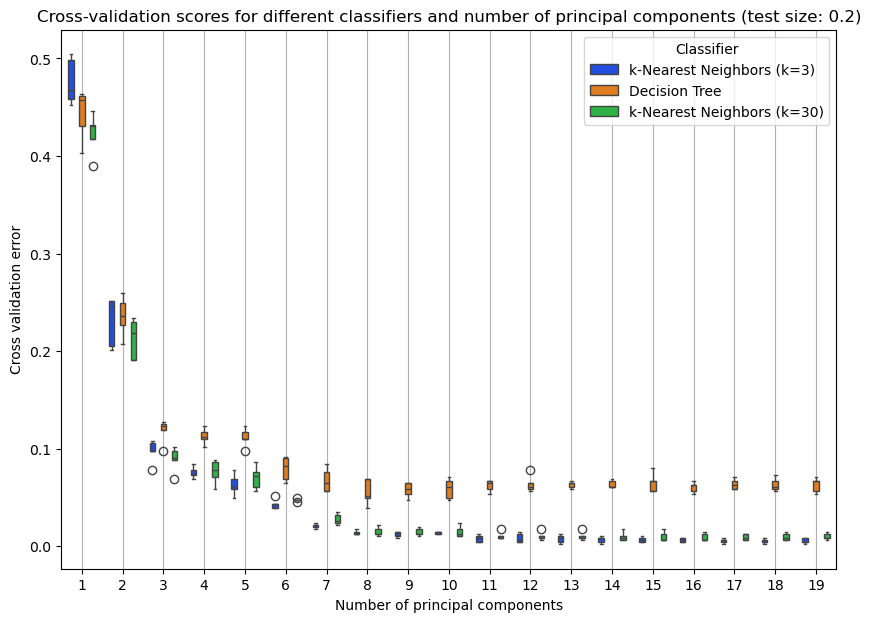

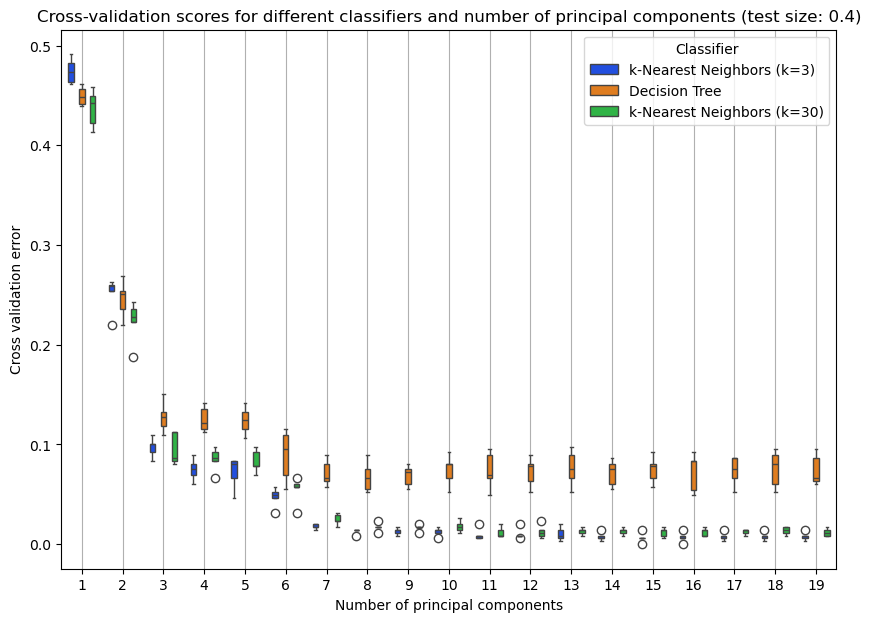

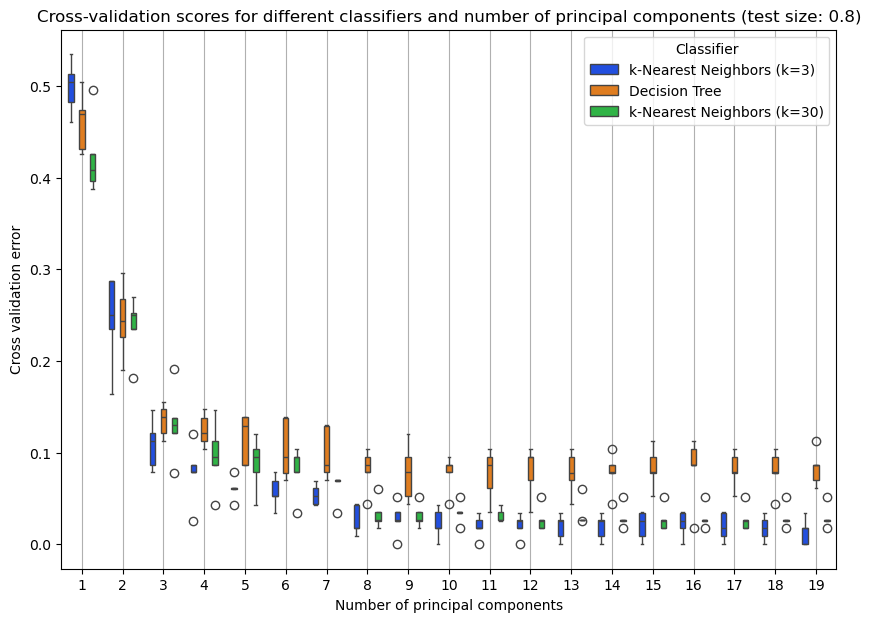

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Convert your results to a DataFrame
for res, test_size in all_results_pca:
    plot_data = []
    for key, values in res.items():
        for value in values:
            for number in value[0]:
                plot_data.append([key, number, value[1]])
    df = pd.DataFrame(plot_data, columns=['Classifier', 'Cross validation error', 'Number of principal components'])

    # Convert 'Label' to string to use as hue
    df['Number of principal components'] = df['Number of principal components'].astype(str)

    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(10, 7))

    # Create the boxplot
    sns.boxplot(x='Number of principal components', y='Cross validation error', hue='Classifier', data=df, ax=ax, palette='bright', gap=0.5)
    ax.set_title(f'Cross-validation scores for different classifiers and number of principal components (test size: {test_size})')
    plt.grid(axis='x')
    plt.show()

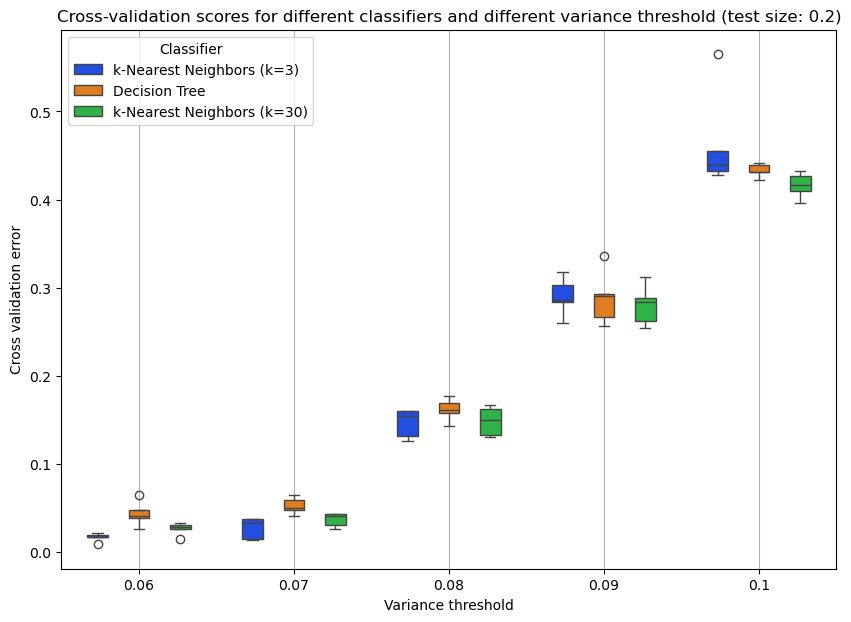

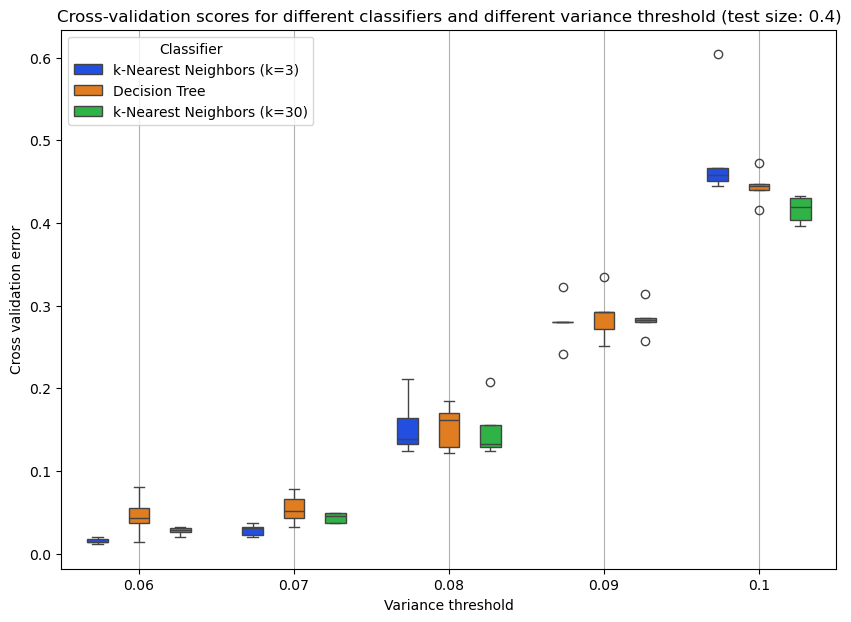

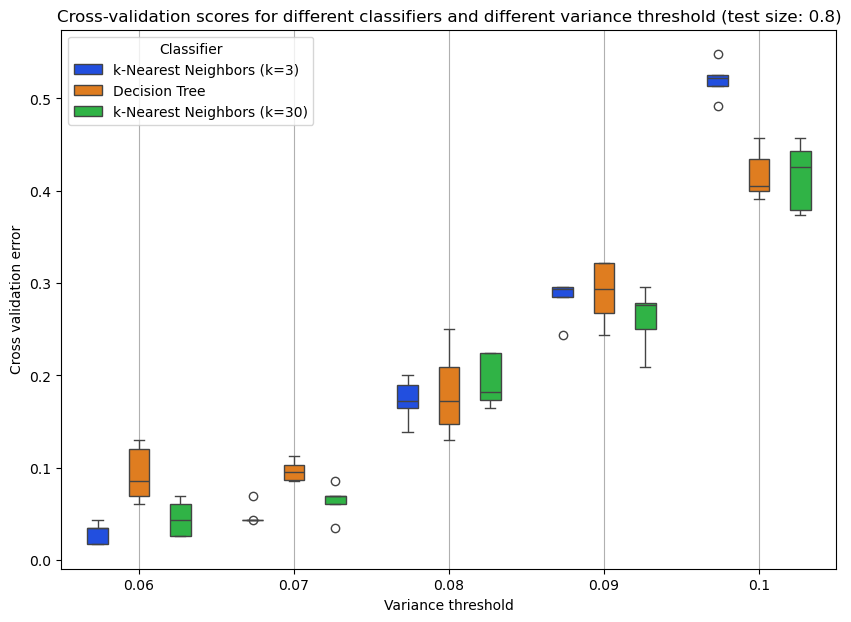

In [78]:
for res, test_size in all_results_var:
    plot_data = []
    for key, values in res.items():
        for value in values:
            for number in value[0]:
                plot_data.append([key, number, value[1]])
    df = pd.DataFrame(plot_data, columns=['Classifier', 'Cross validation error', 'Variance threshold'])

    # Convert 'Label' to string to use as hue
    df['Variance threshold'] = df['Variance threshold'].astype(str)

    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(10, 7))

    # Create the boxplot
    sns.boxplot(x='Variance threshold', y='Cross validation error', hue='Classifier', data=df, ax=ax, palette='bright', gap=0.5)
    ax.set_title(f'Cross-validation scores for different classifiers and different variance threshold (test size: {test_size})')
    plt.grid(axis='x')
    plt.show()